<a href="https://colab.research.google.com/github/tronglinux123/EHR_Transfer_Learning/blob/main/SMOTE_and_XGBClassifier_XGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.cloud import bigquery
from google.colab import auth, drive
import os
# Mount to Google Drive if data on Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/doan_demo')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/doan_demo'

In [ ]:
from typing import Callable
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import warnings
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import gc
warnings.filterwarnings('ignore')



In [ ]:
df = pd.read_csv('x_ray_and_features_data.csv')

diseases = ['pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis', 'lung_infection']
mimic_feats = ['diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough']
img_feats = [str(x) for x in range(18)]
models = [XGBClassifier]
# Keep the necessary data
data = df[img_feats+mimic_feats]
y = df["pneumonia"]
xtr, xte, ytr, yte = train_test_split(data, y, test_size=0.35)
xtr = xtr.reset_index(drop=True)
ytr = ytr.reset_index(drop=True)
xtr

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,-0.101348,-2.571961,-4.431980e-40,-4.638252,-0.079113,1.333738e-39,6.247090e-40,-0.982573,-2.435314,1.817600e-40,...,68,0,NaN,127.0,98.0,7.2,2.28,8.0,0,0
1,0.147129,-2.452241,1.658810e-39,-4.107191,-1.199113,-2.303050e-40,-1.170237e-39,-0.987633,-1.887342,3.456650e-40,...,88,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1.437017,-0.706623,-2.499869e-39,-4.994117,0.165681,-3.792600e-39,-8.677010e-40,1.131101,-1.246397,3.913137e-39,...,79,0,NaN,NaN,NaN,7.3,2.64,6.7,0,0
3,-0.374007,-2.388475,-8.012510e-40,-5.243938,-0.361374,-7.088450e-40,5.696700e-41,-0.645996,-3.093977,8.920700e-40,...,55,0,NaN,NaN,NaN,10.8,4.10,5.9,0,0
4,1.782309,1.463906,-5.419170e-40,-2.316318,1.619469,-6.743400e-40,9.117520e-40,2.576047,-0.117602,4.422093e-39,...,82,0,NaN,NaN,NaN,7.0,2.76,11.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18898,0.686352,0.050397,2.059376e-39,-2.700256,1.034382,-1.171593e-39,2.030889e-39,1.049090,-1.154792,3.167055e-39,...,44,0,NaN,58.0,96.6,12.1,3.56,8.4,0,0
18899,-3.018741,-5.047657,5.529398e-39,-5.207776,-3.966462,4.864802e-39,-1.295528e-39,-3.487835,-5.268620,-7.691705e-39,...,59,0,NaN,NaN,NaN,8.2,3.55,4.5,0,0
18900,-0.694071,-3.336951,2.698127e-39,-4.504345,-1.802002,2.573139e-39,7.355960e-40,-1.531873,-3.109886,-1.273231e-39,...,46,0,NaN,82.0,97.9,10.7,3.35,4.0,0,0
18901,1.322567,0.580757,-2.572120e-39,-2.505910,1.245684,-2.712852e-39,-4.949970e-40,1.500366,-0.696946,3.588494e-39,...,71,0,NaN,NaN,NaN,9.3,2.98,4.8,0,0


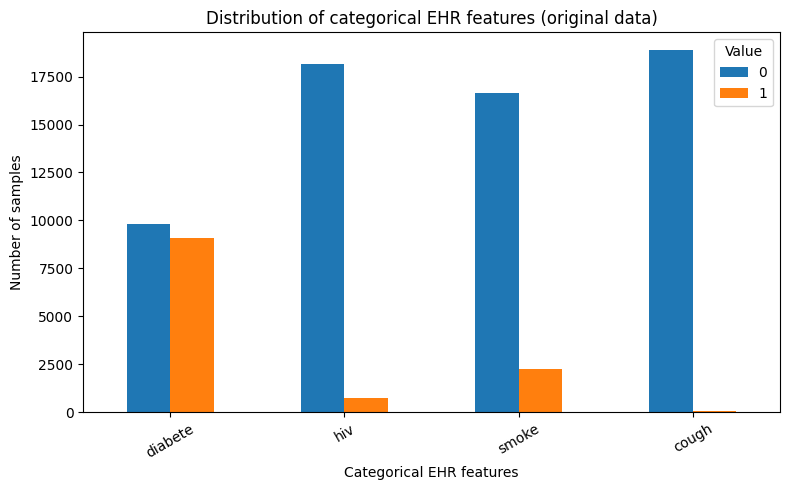

In [ ]:
cat_feats = ['diabete', 'hiv', 'smoke', 'cough']

import matplotlib.pyplot as plt
import pandas as pd

summary_cat = {}

for col in cat_feats:
    counts = xtr[col].value_counts()
    summary_cat[col] = {
        '0': counts.get(0, 0),
        '1': counts.get(1, 0)
    }

df_cat = pd.DataFrame(summary_cat).T

df_cat.plot(kind='bar', figsize=(8,5))
plt.xlabel('Categorical EHR features')
plt.ylabel('Number of samples')
plt.title('Distribution of categorical EHR features (original data)')
plt.xticks(rotation=30)
plt.legend(title='Value')
plt.tight_layout()
plt.show()


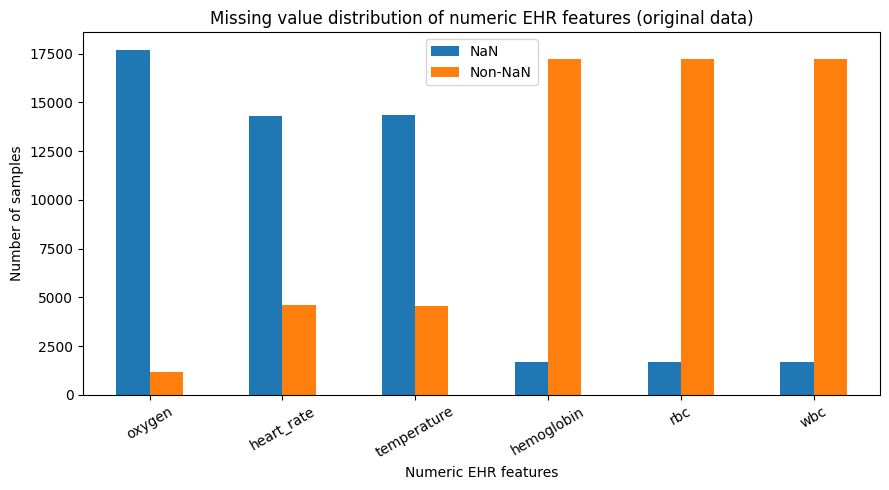

In [ ]:
mimic_numeric = ['oxygen', 'heart_rate', 'temperature',
                 'hemoglobin', 'rbc', 'wbc']

summary_num = {}

for col in mimic_numeric:
    summary_num[col] = {
        'NaN': xtr[col].isna().sum(),
        'Non-NaN': xtr[col].notna().sum()
    }

df_num = pd.DataFrame(summary_num).T

df_num.plot(kind='bar', figsize=(9,5))
plt.xlabel('Numeric EHR features')
plt.ylabel('Number of samples')
plt.title('Missing value distribution of numeric EHR features (original data)')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

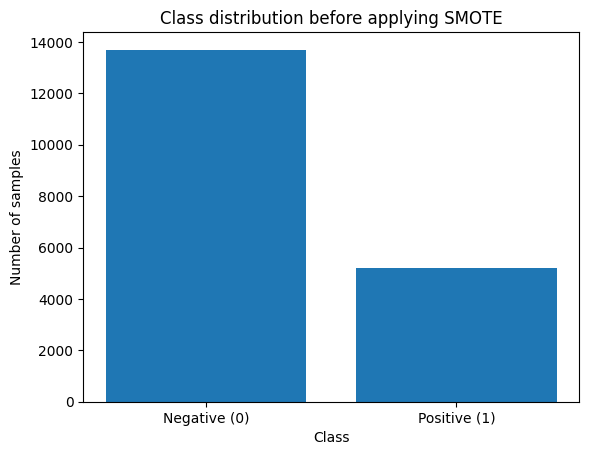

In [ ]:

counts = ytr.value_counts().sort_index()

plt.figure()
plt.bar(['Negative (0)', 'Positive (1)'], counts.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution before applying SMOTE')
plt.show()

In [ ]:
full_feats = img_feats + mimic_feats

sm = SMOTE(sampling_strategy=1, random_state=42)
xtr_img_sm, ytr_sm = sm.fit_resample(xtr[img_feats], ytr)
xtr_img_sm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.101348,-2.571961,-4.431980e-40,-4.638252,-0.079113,1.333738e-39,6.247090e-40,-0.982573,-2.435314,1.817600e-40,-2.037893,2.990965e-39,2.188410e-39,6.472020e-40,-2.757233,-2.391459,0.168212,-2.775303
1,0.147129,-2.452241,1.658810e-39,-4.107191,-1.199113,-2.303050e-40,-1.170237e-39,-0.987633,-1.887342,3.456650e-40,0.554366,1.538595e-39,6.110220e-40,-3.868468e-39,-1.615996,-0.961318,0.465323,-1.582960
2,1.437017,-0.706623,-2.499869e-39,-4.994117,0.165681,-3.792600e-39,-8.677010e-40,1.131101,-1.246397,3.913137e-39,2.324425,4.208768e-39,-1.198945e-39,-5.837455e-39,-1.854781,-1.820766,1.783756,0.172712
3,-0.374007,-2.388475,-8.012510e-40,-5.243938,-0.361374,-7.088450e-40,5.696700e-41,-0.645996,-3.093977,8.920700e-40,0.209848,2.874891e-39,-1.497205e-39,-1.781013e-39,-4.596452,-4.197335,-0.173496,-1.577973
4,1.782309,1.463906,-5.419170e-40,-2.316318,1.619469,-6.743400e-40,9.117520e-40,2.576047,-0.117602,4.422093e-39,0.252629,-1.809956e-39,-2.858817e-39,-5.744885e-39,0.533219,0.515512,2.497866,-0.111335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,-0.658619,-1.179607,-1.454083e-39,-3.112779,-0.679349,-1.904210e-39,3.474825e-39,-0.434998,-1.743794,-1.159107e-39,-1.544876,1.096605e-39,-7.275242e-40,-3.457945e-39,-0.888582,-0.464836,0.308702,-1.447123
27390,-1.093888,-3.460516,1.527407e-39,-3.823269,-1.806945,6.196556e-40,4.198557e-40,-2.090554,-3.068509,-1.387801e-39,-1.826671,4.273599e-39,2.171587e-40,-1.920795e-39,-2.434542,-1.228821,-0.759147,-2.352052
27391,2.110267,2.208686,-2.639273e-39,-3.396354,0.997229,-3.718772e-40,-1.288788e-39,3.708863,-0.394408,3.524986e-39,3.128973,-7.084337e-40,-6.848325e-40,-8.667480e-39,-0.452266,-0.414916,2.958875,1.074335
27392,1.479177,1.086613,-3.704499e-39,-2.799982,0.737343,-3.923050e-39,5.437545e-40,2.273344,-0.894400,2.715464e-39,1.307669,-5.807567e-40,-5.591662e-39,-8.771518e-39,0.678160,0.482522,2.010180,0.846069


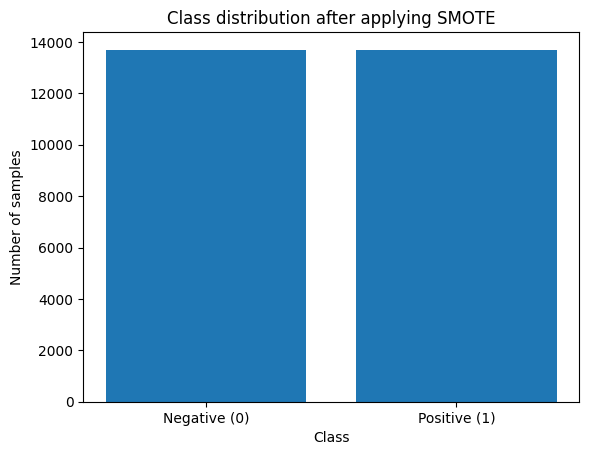

In [ ]:

counts = ytr_sm.value_counts().sort_index()

plt.figure()
plt.bar(['Negative (0)', 'Positive (1)'], counts.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution after applying SMOTE')
plt.show()

In [ ]:
n_original = len(xtr)
n_total = len(xtr_img_sm)
n_synthetic = n_total - n_original
n_synthetic

8491

In [ ]:
xtr_final = pd.DataFrame()
xtr_final[img_feats] = xtr_img_sm
xtr_final.loc[:n_original-1, mimic_feats] = xtr[mimic_feats].values
xtr_final.loc[n_original:, mimic_feats] = np.nan
X_train_final = xtr_final
y_train_final = ytr_sm
X_train_final

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,-0.101348,-2.571961,-4.431980e-40,-4.638252,-0.079113,1.333738e-39,6.247090e-40,-0.982573,-2.435314,1.817600e-40,...,68.0,0.0,NaN,127.0,98.0,7.2,2.28,8.0,0.0,0.0
1,0.147129,-2.452241,1.658810e-39,-4.107191,-1.199113,-2.303050e-40,-1.170237e-39,-0.987633,-1.887342,3.456650e-40,...,88.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1.437017,-0.706623,-2.499869e-39,-4.994117,0.165681,-3.792600e-39,-8.677010e-40,1.131101,-1.246397,3.913137e-39,...,79.0,0.0,NaN,NaN,NaN,7.3,2.64,6.7,0.0,0.0
3,-0.374007,-2.388475,-8.012510e-40,-5.243938,-0.361374,-7.088450e-40,5.696700e-41,-0.645996,-3.093977,8.920700e-40,...,55.0,0.0,NaN,NaN,NaN,10.8,4.10,5.9,0.0,0.0
4,1.782309,1.463906,-5.419170e-40,-2.316318,1.619469,-6.743400e-40,9.117520e-40,2.576047,-0.117602,4.422093e-39,...,82.0,0.0,NaN,NaN,NaN,7.0,2.76,11.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,-0.658619,-1.179607,-1.454083e-39,-3.112779,-0.679349,-1.904210e-39,3.474825e-39,-0.434998,-1.743794,-1.159107e-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27390,-1.093888,-3.460516,1.527407e-39,-3.823269,-1.806945,6.196556e-40,4.198557e-40,-2.090554,-3.068509,-1.387801e-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27391,2.110267,2.208686,-2.639273e-39,-3.396354,0.997229,-3.718772e-40,-1.288788e-39,3.708863,-0.394408,3.524986e-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27392,1.479177,1.086613,-3.704499e-39,-2.799982,0.737343,-3.923050e-39,5.437545e-40,2.273344,-0.894400,2.715464e-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cat_feats = ['diabete', 'hiv', 'smoke', 'cough']
X_train_img = xtr[img_feats]
X_train_labels = xtr[cat_feats]
X_train_labels

,diabete,hiv,smoke,cough
0,0,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,0,0
4,1,0,0,0
...,...,...,...,...
18898,0,0,0,0
18899,0,0,0,0
18900,0,0,0,0
18901,1,0,0,0


In [ ]:
X_synth_img = X_train_final.loc[n_original:, img_feats]
X_synth_img

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
18903,1.941010,1.532650,-3.808492e-39,-3.684093,1.727021,-2.572269e-39,-4.743105e-40,2.968210,-0.402731,5.509322e-39,2.725255,4.534670e-40,-1.518170e-39,-6.515850e-39,-0.839004,-1.173087,2.568174,0.652471
18904,0.189425,-0.793917,-6.605582e-40,-2.553818,-0.230673,-1.764312e-39,1.616097e-39,0.216414,-1.195019,2.886269e-39,-0.962988,-1.571037e-39,3.463542e-40,-3.944691e-39,-0.172311,-0.335652,1.157379,-1.104135
18905,3.905292,3.002515,-6.403933e-39,-1.535996,2.236226,-9.503411e-39,-4.390345e-39,4.020207,2.102542,7.531733e-39,3.253706,2.359917e-39,-1.168369e-38,-1.427438e-38,4.193513,2.650012,4.527848,2.702673
18906,2.571571,1.612474,-1.770274e-39,-2.291256,2.633023,-3.779028e-39,-1.010982e-39,2.837409,1.723154,7.519409e-39,1.806850,6.966954e-40,-2.977349e-39,-9.963615e-39,2.036554,1.682356,3.747144,0.193900
18907,1.919404,0.031027,4.080256e-40,-4.088664,1.090846,-4.207601e-39,-2.211627e-39,1.636821,-0.937907,7.125923e-39,3.134771,1.802677e-39,-2.139167e-40,-6.277254e-39,-1.694253,-0.214767,2.317157,0.747047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,-0.658619,-1.179607,-1.454083e-39,-3.112779,-0.679349,-1.904210e-39,3.474825e-39,-0.434998,-1.743794,-1.159107e-39,-1.544876,1.096605e-39,-7.275242e-40,-3.457945e-39,-0.888582,-0.464836,0.308702,-1.447123
27390,-1.093888,-3.460516,1.527407e-39,-3.823269,-1.806945,6.196556e-40,4.198557e-40,-2.090554,-3.068509,-1.387801e-39,-1.826671,4.273599e-39,2.171587e-40,-1.920795e-39,-2.434542,-1.228821,-0.759147,-2.352052
27391,2.110267,2.208686,-2.639273e-39,-3.396354,0.997229,-3.718772e-40,-1.288788e-39,3.708863,-0.394408,3.524986e-39,3.128973,-7.084337e-40,-6.848325e-40,-8.667480e-39,-0.452266,-0.414916,2.958875,1.074335
27392,1.479177,1.086613,-3.704499e-39,-2.799982,0.737343,-3.923050e-39,5.437545e-40,2.273344,-0.894400,2.715464e-39,1.307669,-5.807567e-40,-5.591662e-39,-8.771518e-39,0.678160,0.482522,2.010180,0.846069


In [ ]:
models_cat = {}
for col in cat_feats:
    mask = X_train_labels[col]
    n_pos = mask.sum()
    n_neg = len(mask) - n_pos
    model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight = n_neg / n_pos
    )

    model.fit(X_train_img, X_train_labels[col])
    models_cat[col] = model

preds = {}

for col in cat_feats:
    preds[col] = models_cat[col].predict(X_synth_img)

for col in cat_feats:
    X_train_final.loc[n_original:, col] = preds[col]

In [ ]:
import pandas as pd

summary = {}

for col in cat_feats:
    counts = X_train_final.loc[:n_original-1, col].value_counts()
    summary[col] = {
        "0_count": counts.get(0, 0),
        "1_count": counts.get(1, 0)
    }

df_summary = pd.DataFrame(summary).T
print(df_summary)


         0_count  1_count
diabete     9707     9196
hiv        18199      704
smoke      16636     2267
cough      18870       33


In [ ]:
import pandas as pd

summary = {}

for col in cat_feats:
    counts = X_train_final.loc[n_original:, col].value_counts()
    summary[col] = {
        "0_count": counts.get(0, 0),
        "1_count": counts.get(1, 0)
    }

df_summary = pd.DataFrame(summary).T
print(df_summary)


         0_count  1_count
diabete     4423     4068
hiv         6293     2198
smoke       5595     2896
cough       8416       75


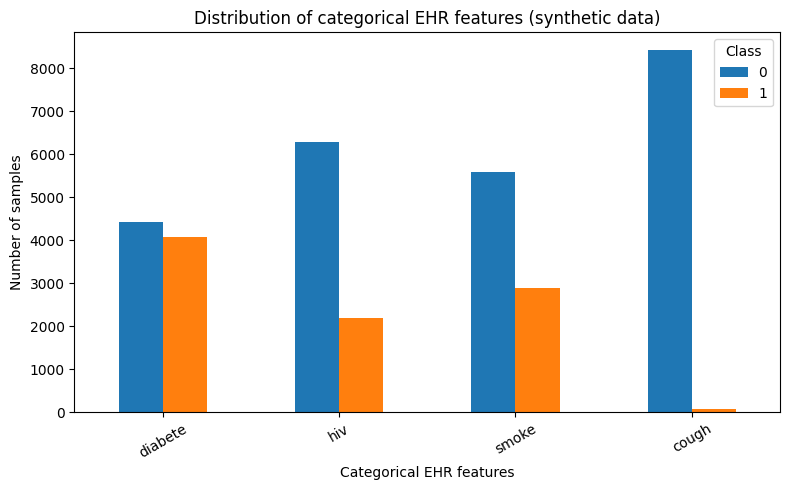

In [ ]:
cat_feats = ['diabete', 'hiv', 'smoke', 'cough']

summary_cat = {}

for col in cat_feats:
    counts = df_summary.loc[col]   # hoặc xtr[col].value_counts()
    summary_cat[col] = {
        '0': counts.get(0, 0),
        '1': counts.get(1, 0)
    }

df_cat = pd.DataFrame(summary_cat).T

df_cat.plot(
    kind='bar',
    figsize=(8, 5)
)

plt.xlabel('Categorical EHR features')
plt.ylabel('Number of samples')
plt.title('Distribution of categorical EHR features (synthetic data)')
plt.xticks(rotation=30)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

In [ ]:
X_train_final

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,-0.101348,-2.571961,-4.431980e-40,-4.638252,-0.079113,1.333738e-39,6.247090e-40,-0.982573,-2.435314,1.817600e-40,...,68.0,0.0,NaN,127.0,98.0,7.2,2.28,8.0,0.0,0.0
1,0.147129,-2.452241,1.658810e-39,-4.107191,-1.199113,-2.303050e-40,-1.170237e-39,-0.987633,-1.887342,3.456650e-40,...,88.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1.437017,-0.706623,-2.499869e-39,-4.994117,0.165681,-3.792600e-39,-8.677010e-40,1.131101,-1.246397,3.913137e-39,...,79.0,0.0,NaN,NaN,NaN,7.3,2.64,6.7,0.0,0.0
3,-0.374007,-2.388475,-8.012510e-40,-5.243938,-0.361374,-7.088450e-40,5.696700e-41,-0.645996,-3.093977,8.920700e-40,...,55.0,0.0,NaN,NaN,NaN,10.8,4.10,5.9,0.0,0.0
4,1.782309,1.463906,-5.419170e-40,-2.316318,1.619469,-6.743400e-40,9.117520e-40,2.576047,-0.117602,4.422093e-39,...,82.0,0.0,NaN,NaN,NaN,7.0,2.76,11.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,-0.658619,-1.179607,-1.454083e-39,-3.112779,-0.679349,-1.904210e-39,3.474825e-39,-0.434998,-1.743794,-1.159107e-39,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
27390,-1.093888,-3.460516,1.527407e-39,-3.823269,-1.806945,6.196556e-40,4.198557e-40,-2.090554,-3.068509,-1.387801e-39,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
27391,2.110267,2.208686,-2.639273e-39,-3.396354,0.997229,-3.718772e-40,-1.288788e-39,3.708863,-0.394408,3.524986e-39,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
27392,1.479177,1.086613,-3.704499e-39,-2.799982,0.737343,-3.923050e-39,5.437545e-40,2.273344,-0.894400,2.715464e-39,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [ ]:
mimic_numeric = ['oxygen', 'heart_rate', 'temperature',
                   'hemoglobin', 'rbc', 'wbc']

models_mask = {}
models_value = {}

In [ ]:
mimic_numeric = ['oxygen', 'heart_rate', 'temperature',
                   'hemoglobin', 'rbc', 'wbc']
models_mask = {}
models_value = {}

for num in mimic_numeric:
    mask = xtr[num].notna().astype(int)
    n_pos = mask.sum()
    n_neg = len(mask) - n_pos

    X_train_num_input = pd.concat([X_train_img, X_train_labels], axis=1)

    mask_model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight = n_neg / n_pos
    )

    mask_model.fit(X_train_num_input, mask)
    models_mask[num] = mask_model

    value_model = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    value_model.fit(X_train_num_input[mask == 1], xtr.loc[mask == 1, num])
    models_value[num] = value_model


X_synth_input = pd.concat([X_synth_img, X_train_final.loc[n_original:, cat_feats]], axis=1)

for num in mimic_numeric:
    mask_pred = models_mask[num].predict(X_synth_input)
    idx_has_value = (mask_pred == 1)

    if idx_has_value.sum() > 0:
        values = models_value[num].predict(X_synth_input[idx_has_value])
        X_train_final.loc[n_original:].loc[idx_has_value, num] = values
X_train_final

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,-0.101348,-2.571961,-4.431980e-40,-4.638252,-0.079113,1.333738e-39,6.247090e-40,-0.982573,-2.435314,1.817600e-40,...,68.0,0.0,NaN,127.000000,98.000000,7.20000,2.280000,8.000000,0.0,0.0
1,0.147129,-2.452241,1.658810e-39,-4.107191,-1.199113,-2.303050e-40,-1.170237e-39,-0.987633,-1.887342,3.456650e-40,...,88.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1.437017,-0.706623,-2.499869e-39,-4.994117,0.165681,-3.792600e-39,-8.677010e-40,1.131101,-1.246397,3.913137e-39,...,79.0,0.0,NaN,NaN,NaN,7.30000,2.640000,6.700000,0.0,0.0
3,-0.374007,-2.388475,-8.012510e-40,-5.243938,-0.361374,-7.088450e-40,5.696700e-41,-0.645996,-3.093977,8.920700e-40,...,55.0,0.0,NaN,NaN,NaN,10.80000,4.100000,5.900000,0.0,0.0
4,1.782309,1.463906,-5.419170e-40,-2.316318,1.619469,-6.743400e-40,9.117520e-40,2.576047,-0.117602,4.422093e-39,...,82.0,0.0,NaN,NaN,NaN,7.00000,2.760000,11.500000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,-0.658619,-1.179607,-1.454083e-39,-3.112779,-0.679349,-1.904210e-39,3.474825e-39,-0.434998,-1.743794,-1.159107e-39,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
27390,-1.093888,-3.460516,1.527407e-39,-3.823269,-1.806945,6.196556e-40,4.198557e-40,-2.090554,-3.068509,-1.387801e-39,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
27391,2.110267,2.208686,-2.639273e-39,-3.396354,0.997229,-3.718772e-40,-1.288788e-39,3.708863,-0.394408,3.524986e-39,...,NaN,0.0,35.076172,91.934967,97.972206,9.91905,3.438402,9.156072,0.0,0.0
27392,1.479177,1.086613,-3.704499e-39,-2.799982,0.737343,-3.923050e-39,5.437545e-40,2.273344,-0.894400,2.715464e-39,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [ ]:
X_synth = X_train_final.loc[n_original:, mimic_numeric]

summary_num = {}

for col in mimic_numeric:
    nan_count = X_synth[col].isna().sum()
    non_nan_count = X_synth[col].notna().sum()

    summary_num[col] = {
        "NaN": nan_count,
        "Non-NaN": non_nan_count
    }

df_summary_num = pd.DataFrame(summary_num).T
print(df_summary_num)

              NaN  Non-NaN
oxygen       5777     2714
heart_rate   4902     3589
temperature  4909     3582
hemoglobin   3143     5348
rbc          3143     5348
wbc          3143     5348


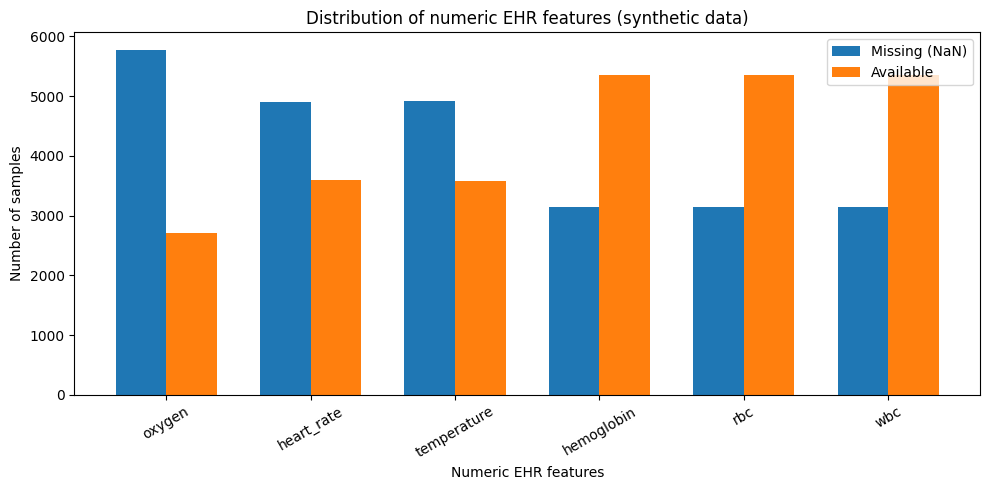

In [ ]:
labels = df_summary_num.index
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, df_summary_num['NaN'], width, label='Missing (NaN)')
plt.bar(x + width/2, df_summary_num['Non-NaN'], width, label='Available')

plt.xticks(x, labels, rotation=30)
plt.xlabel('Numeric EHR features')
plt.ylabel('Number of samples')
plt.title('Distribution of numeric EHR features (synthetic data)')
plt.legend()

plt.tight_layout()
plt.show()
